In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import pickle

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

import funciones_auxiliares as aux

warnings.filterwarnings("ignore")
sns.set_style()
plt.rcParams["figure.figsize"] = (12, 6)

# Feature Engineering

In [11]:
df = pd.read_csv("RegistroTumores_FALP.csv")


In [12]:
# Deja solo el cancer de mama
mama = df.query("CATEGORIA == 'MAMA'")

# Deja solo los registros con estadio
mama_con_estadio = mama[~mama["ESTADIO"].isna()]

# Deja solo los registros sin estadio
mama_sin_estadio = mama[mama["ESTADIO"].isna()]

In [13]:
mama_preproc = aux.preprocesar_dataset_cancer_mama(mama_con_estadio)
mama_sin_estadio_preproc = aux.preprocesar_dataset_cancer_mama(mama_sin_estadio)


In [14]:
X = mama_preproc.drop(columns="STATUS")
y = mama_preproc["STATUS"]


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.333, random_state=1)


# Modelacion

## Declaracion de modelos y grillas de hiperparametros

In [10]:
modelos = [
    {
        "nombre": "Naive Bayes",
        "modelo": MultinomialNB(),
        "param_grid": {
            "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
            "fit_prior": [True, False],
        },
    },
    {
        "nombre": "Arbol Clasificacion",
        "modelo": DecisionTreeClassifier(),
        "param_grid": {
            "max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
            "max_leaf_nodes": [10, 50, 100],
            "criterion": ["gini", "entropy"],
            "min_samples_split": [0.05, 2],
        },
    },
    {
        "nombre": "Random Forest",
        "modelo": RandomForestClassifier(min_samples_split=2),
        "param_grid": {
            "max_depth": [5, 6, 7, 8, 9, 10],
            "n_estimators": [500, 600, 700, 800, 900, 1000],
            "max_leaf_nodes": [10, 50, 100],
        },
    },
    {
        "nombre": "Gradient Bossting",
        "modelo": GradientBoostingClassifier(min_samples_split=2),
        "param_grid": {
            "max_depth": [5, 6, 7, 8, 9, 10],
            "learning_rate": [0.001, 0.01, 0.1, 1],
            "max_leaf_nodes": [10, 50, 100],
        },
    },
    {
        "nombre": "SVM",
        "modelo": SVC(),
        "param_grid": {"C": [0.1, 1, 10, 100], "kernel": ["linear", "poly"], "degree": [2, 3, 4]},
    },
]

## Entrenamiento de Modelos

Training Naive Bayes ...
--------------Resultados Conjunto de Entrenamiento-----------------
Los resultados en la busqueda de hiperparametros son:


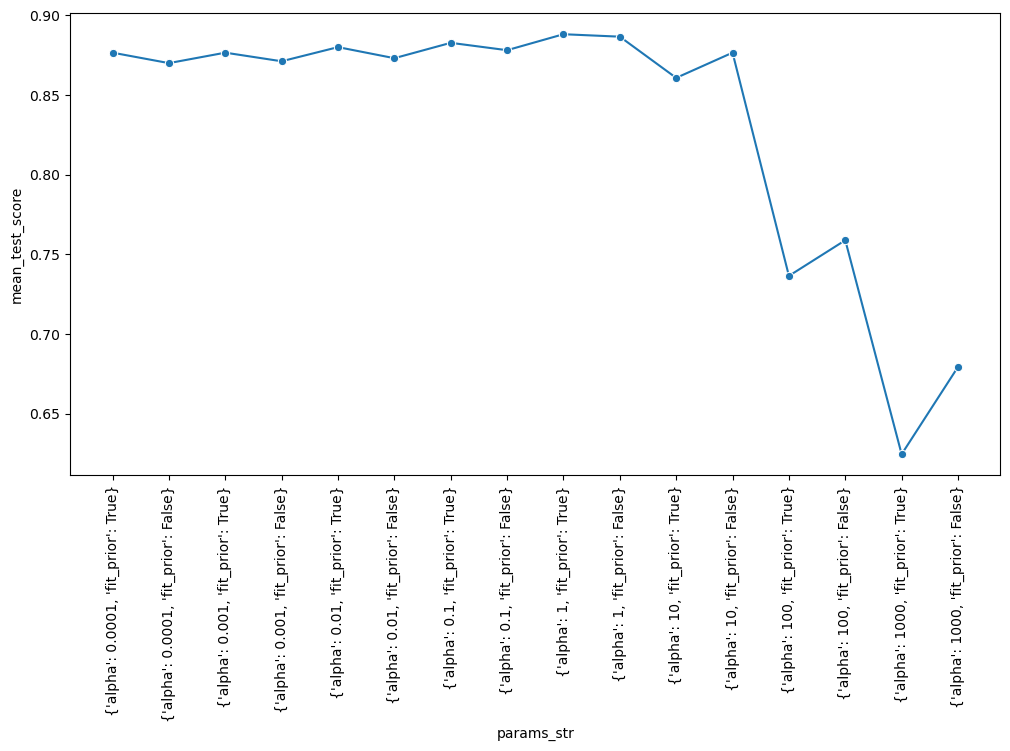

Los mejores parametros fueron: {'alpha': 1, 'fit_prior': True}
El mejor desempeno fue: 0.8880665967371171


--------------Resultados Conjunto de Validacion-----------------
Los resultados en el conjunto de validacion son:
              precision    recall  f1-score   support

           1       0.94      0.93      0.93       446
           2       0.82      0.86      0.84       488
           3       0.88      0.83      0.85       361

    accuracy                           0.88      1295
   macro avg       0.88      0.87      0.88      1295
weighted avg       0.88      0.88      0.88      1295

---------------------------------------------------------------------
Training Arbol Clasificacion ...
--------------Resultados Conjunto de Entrenamiento-----------------
Los resultados en la busqueda de hiperparametros son:


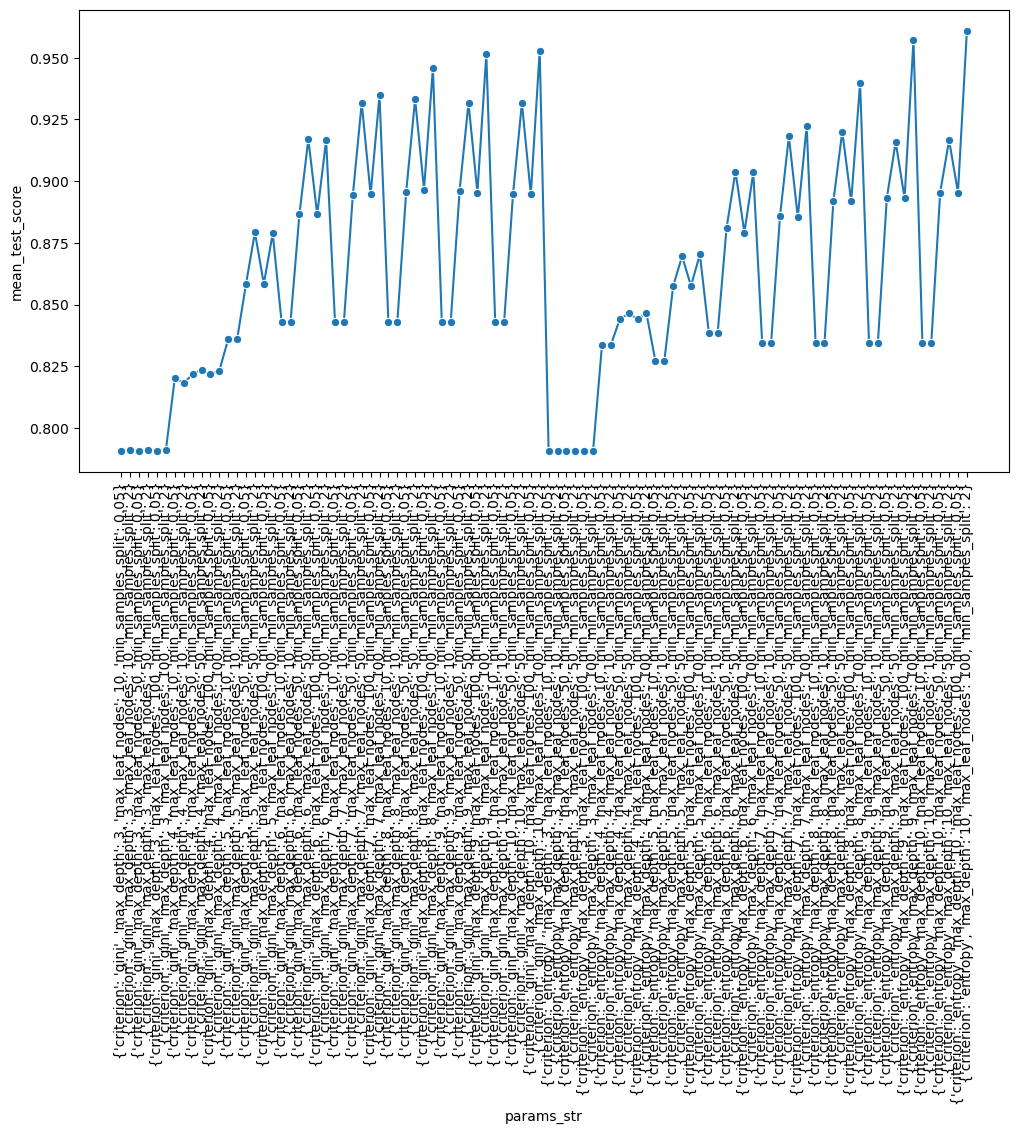

Los mejores parametros fueron: {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 100, 'min_samples_split': 2}
El mejor desempeno fue: 0.9610209714255957


--------------Resultados Conjunto de Validacion-----------------
Los resultados en el conjunto de validacion son:
              precision    recall  f1-score   support

           1       0.99      0.95      0.97       446
           2       0.93      0.99      0.96       488
           3       0.99      0.97      0.98       361

    accuracy                           0.97      1295
   macro avg       0.97      0.97      0.97      1295
weighted avg       0.97      0.97      0.97      1295

---------------------------------------------------------------------
Training Random Forest ...
--------------Resultados Conjunto de Entrenamiento-----------------
Los resultados en la busqueda de hiperparametros son:


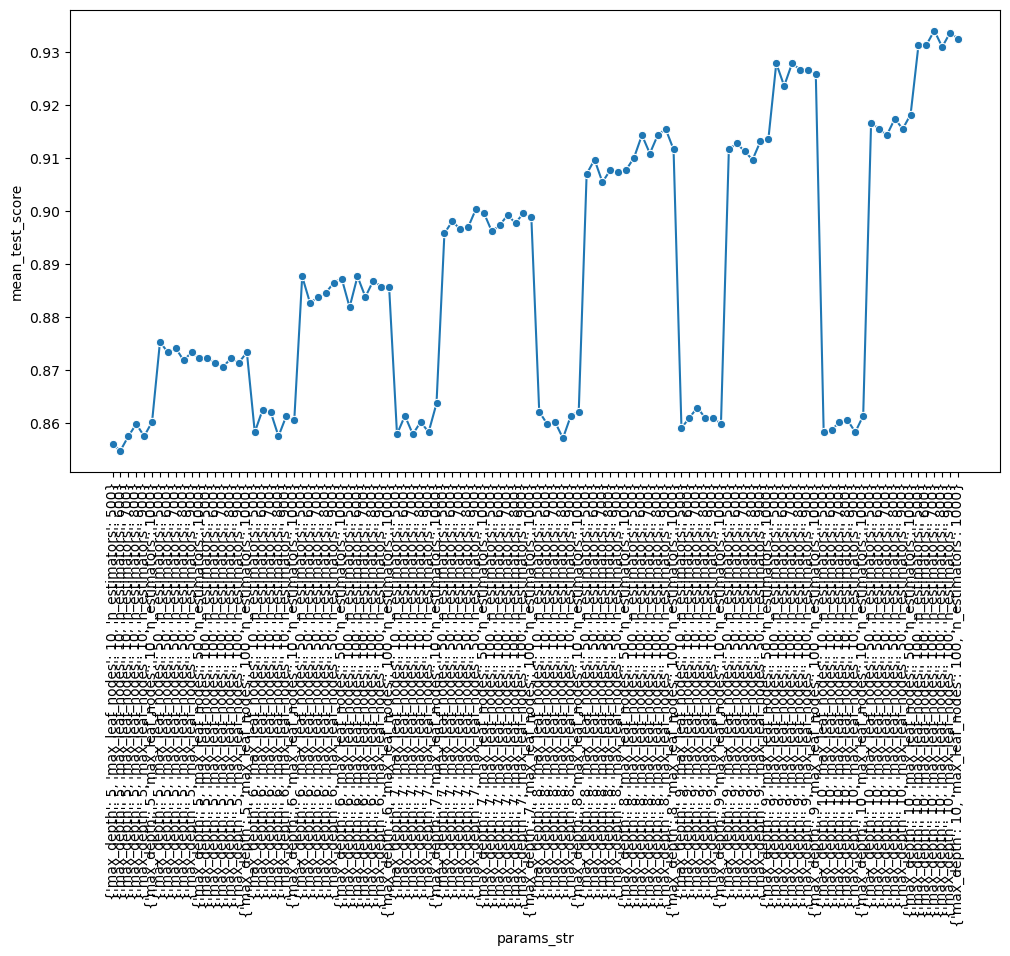

Los mejores parametros fueron: {'max_depth': 10, 'max_leaf_nodes': 100, 'n_estimators': 700}
El mejor desempeno fue: 0.9339969201240876


--------------Resultados Conjunto de Validacion-----------------
Los resultados en el conjunto de validacion son:
              precision    recall  f1-score   support

           1       0.97      0.93      0.95       446
           2       0.89      0.97      0.93       488
           3       0.99      0.92      0.95       361

    accuracy                           0.94      1295
   macro avg       0.95      0.94      0.94      1295
weighted avg       0.95      0.94      0.94      1295

---------------------------------------------------------------------
Training Gradient Bossting ...
--------------Resultados Conjunto de Entrenamiento-----------------
Los resultados en la busqueda de hiperparametros son:


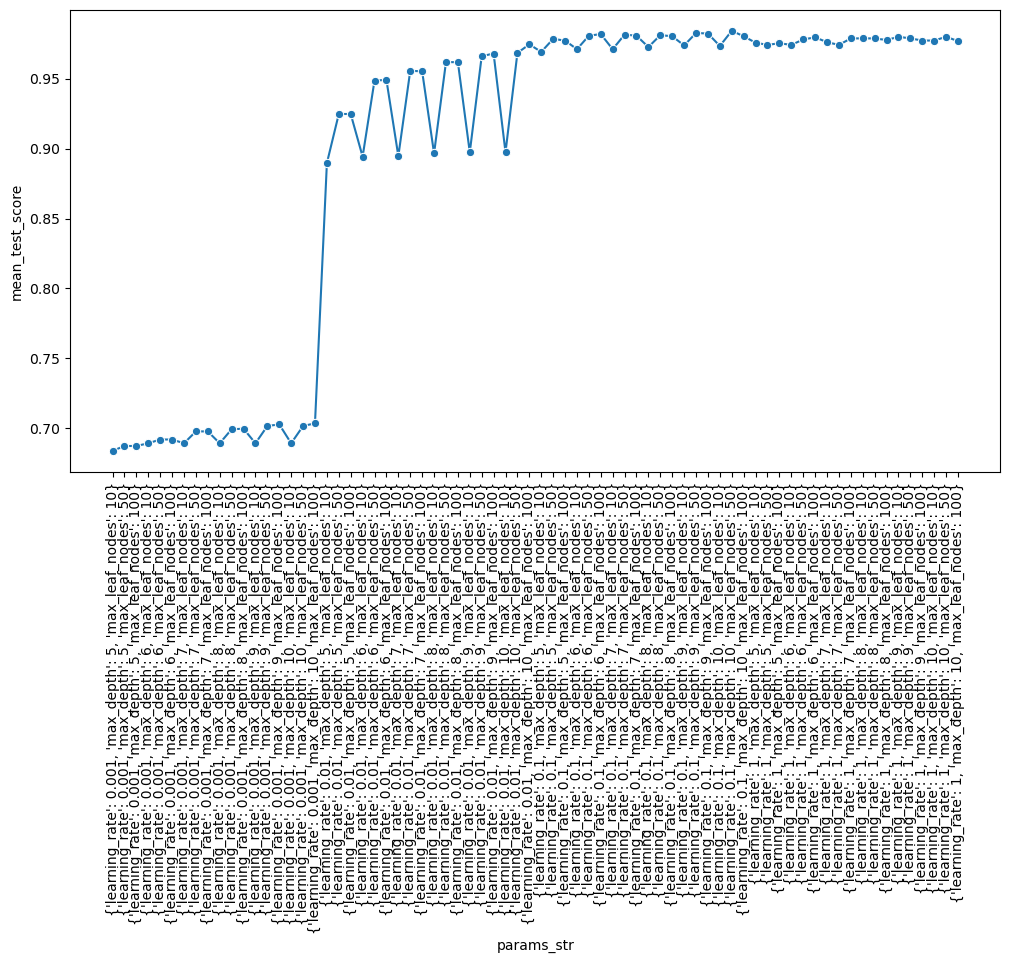

Los mejores parametros fueron: {'learning_rate': 0.1, 'max_depth': 10, 'max_leaf_nodes': 50}
El mejor desempeno fue: 0.9841773234836818


--------------Resultados Conjunto de Validacion-----------------
Los resultados en el conjunto de validacion son:
              precision    recall  f1-score   support

           1       1.00      0.98      0.99       446
           2       0.98      1.00      0.99       488
           3       1.00      0.99      1.00       361

    accuracy                           0.99      1295
   macro avg       0.99      0.99      0.99      1295
weighted avg       0.99      0.99      0.99      1295

---------------------------------------------------------------------
Training SVM ...
--------------Resultados Conjunto de Entrenamiento-----------------
Los resultados en la busqueda de hiperparametros son:


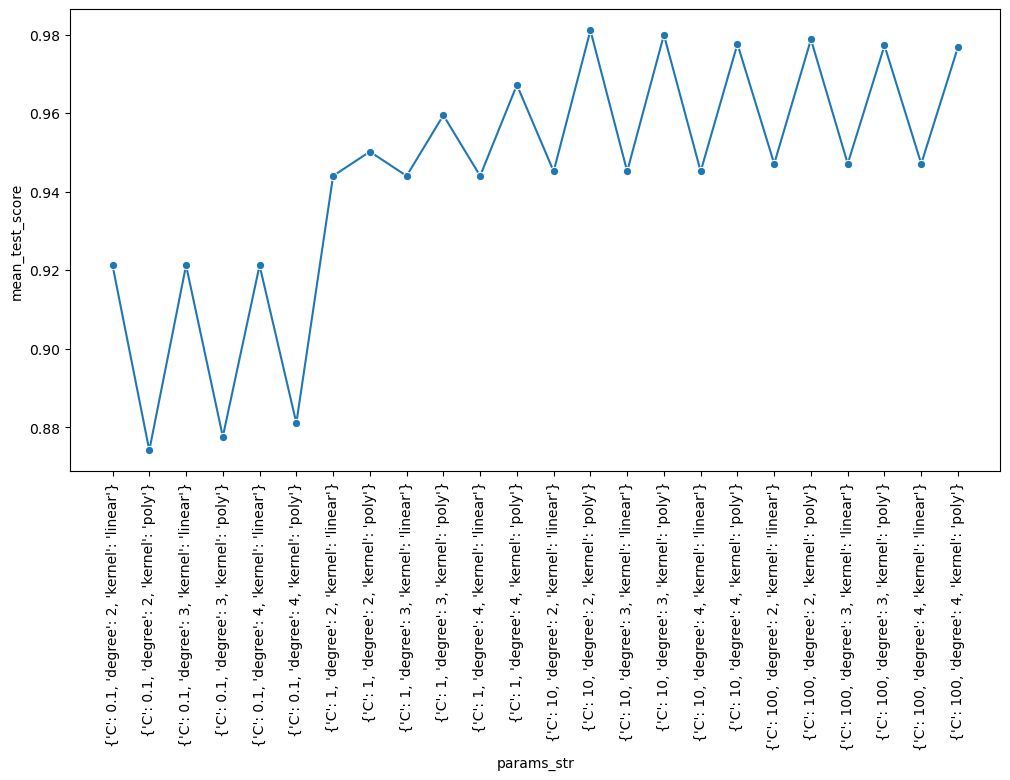

Los mejores parametros fueron: {'C': 10, 'degree': 2, 'kernel': 'poly'}
El mejor desempeno fue: 0.9810892643262585


--------------Resultados Conjunto de Validacion-----------------
Los resultados en el conjunto de validacion son:
              precision    recall  f1-score   support

           1       0.99      0.97      0.98       446
           2       0.97      0.99      0.98       488
           3       0.99      0.99      0.99       361

    accuracy                           0.98      1295
   macro avg       0.99      0.98      0.99      1295
weighted avg       0.98      0.98      0.98      1295

---------------------------------------------------------------------


In [211]:
aux.entrenar_ensamble_de_modelos_gridcv(modelos, X_train, X_test, y_train, y_test)


## Exportacion de Modelos Entrenados

In [215]:
with open("modelos_serializados_cancer_mama.pickle", "wb") as file:
    pickle.dump(modelos, file)
